In [1]:
import os.path as osp
import logging
import glob
import matplotlib.pyplot as plt

from muben.utils.macro import (
    DatasetNames,
    ModelNames,
    UncertaintyMethods,
    FINGERPRINT_FEATURE_TYPES,
)

from muben.utils.metrics import classification_metrics, regression_metrics
from muben.utils.io import set_logging, load_results

logger = logging.getLogger(__name__)

set_logging()


In [2]:
result_folder = osp.join('output', 'al')
dataset_name = 'qm9'
# model_name = 'ChemBERTa'
model_name = 'DNN-rdkit'
seed = 0
n_al_loop = 20

task = None
if dataset_name in DatasetNames.options("classification"):
    task = "classification"
    metrics = classification_metrics
    uncertainty_methods = UncertaintyMethods.options("classification")
elif dataset_name in DatasetNames.options("regression"):
    task = "regression"
    metrics = regression_metrics
    uncertainty_methods = UncertaintyMethods.options("regression")
else:
    raise ValueError(f'Unknown dataset name: {dataset_name}')


In [3]:
result_dirs = glob.glob(osp.join(result_folder, dataset_name, model_name, '*'))
discovered_uncertainty_methods = [osp.basename(d) for d in result_dirs]
uncertainty_methods = [m for m in uncertainty_methods if m in discovered_uncertainty_methods]
logger.info(f'Uncertainty methods: {uncertainty_methods}')

result_dirs = [osp.join(result_folder, dataset_name, model_name, m) for m in uncertainty_methods]

12/01/2023 17:07:34 - INFO - __main__ -   Uncertainty methods: ['none', 'MCDropout', 'SWAG', 'BBP', 'SGLD']


In [4]:
al_metrics = dict()

for uncertainty_method in uncertainty_methods:
    al_metric_dict = dict()

    logger.info(f'Uncertainty method: {uncertainty_method}')

    result_dir = osp.join(result_folder, dataset_name, model_name, uncertainty_method)

    al_result_dirs = [osp.join(result_dir, f"seed-{seed}", f"al-{i}") for i in range(n_al_loop)]
    for i in range(n_al_loop+1):
        al_result_dir = osp.join(result_dir, f"seed-{seed}", f"al-{i}")

        if not osp.exists(al_result_dir):
            logger.warning(f"AL result dir does not exist: {al_result_dir}")

        test_result_paths = glob.glob(
            osp.join(al_result_dir, "preds", "*.pt")
        )

        if not test_result_paths:
            continue

        preds, variances, lbs, masks = load_results(test_result_paths)

        if variances is not None:  # regression
            metrics = regression_metrics(preds, variances, lbs, masks, exclude=["ce", "ece", "mce"])
        else:  # classification
            metrics = classification_metrics(preds, lbs, masks, exclude=["ce", "ece", "mce"])
        for metric_name, metric_value in metrics.items():
            al_metric_dict.setdefault(metric_name, []).append(metric_value['macro-avg'])
    
    al_metrics[uncertainty_method] = al_metric_dict

12/01/2023 17:07:34 - INFO - __main__ -   Uncertainty method: none
12/01/2023 17:07:34 - INFO - __main__ -   Uncertainty method: MCDropout
12/01/2023 17:07:39 - INFO - __main__ -   Uncertainty method: SWAG
12/01/2023 17:07:44 - INFO - __main__ -   Uncertainty method: BBP
12/01/2023 17:07:48 - INFO - __main__ -   Uncertainty method: SGLD


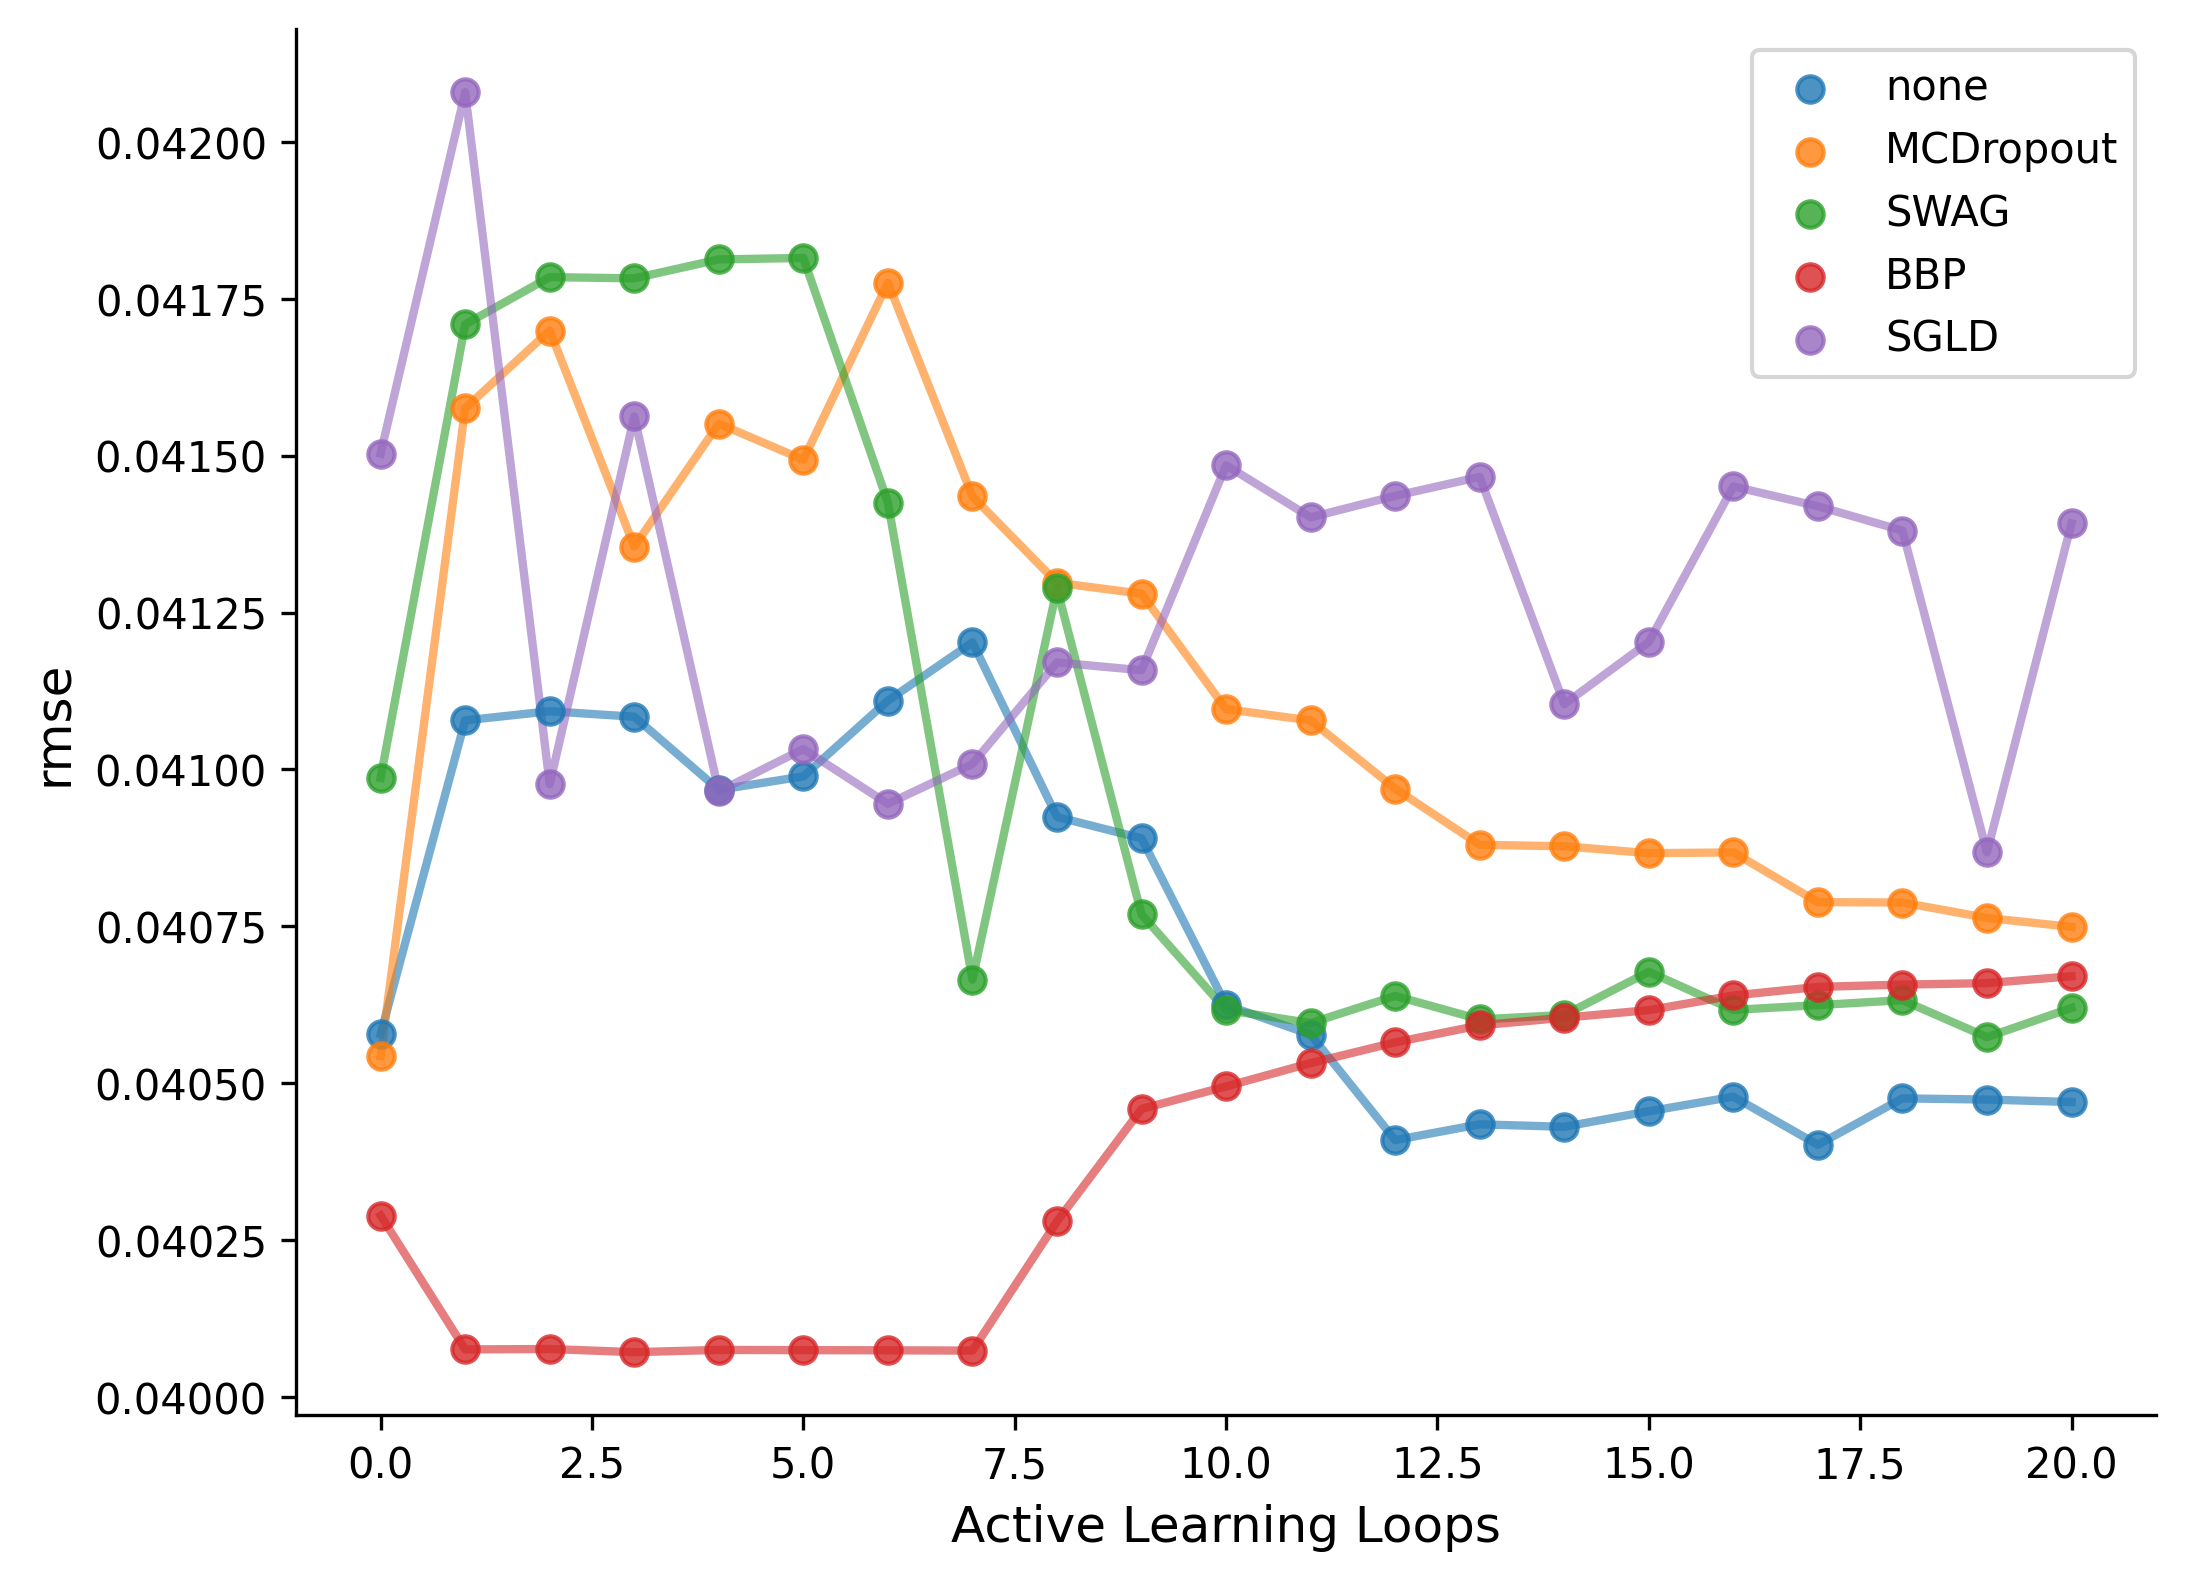

In [5]:
uq_method = "none"

metric_name = "roc-auc" if task == "classification" else "rmse"
# metric_name = "roc-auc"

# plot figure
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
x_range = list(range(0, n_al_loop+1))

for uq_method in uncertainty_methods:

    ax.plot(x_range, al_metrics[uq_method][metric_name], alpha=0.6, linewidth=2, zorder=10)
    ax.scatter(
        x_range,
        al_metrics[uq_method][metric_name],
        s=40,
        alpha=0.8,
        zorder=100,
        label=uq_method,
    )

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.set_xlabel("Active Learning Loops", fontsize=12)
    ax.set_ylabel(metric_name, fontsize=12)
    plt.legend()
